# CubiCasa5K Dataset Processing - Enhanced Version

This notebook provides an enhanced processing pipeline for the CubiCasa5K dataset with:
- Proper 60/40 train/test splitting
- Smart image processing and resizing
- Comprehensive metadata extraction
- Detailed statistical analysis
- Quality visualizations

## Setup and Imports

In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image, ImageDraw, ImageEnhance
import cv2
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple, Optional, Set
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
import shutil
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All imports successful!")

✅ All imports successful!


## Configuration

In [2]:
# Configuration
DATA_DIR = Path('../data')
CUBICASA_DIR = DATA_DIR / 'cubicasa5k'
PROCESSED_DIR = DATA_DIR / 'processed'
OUTPUT_DIR = Path('../outputs')

# Processing settings
TARGET_SIZE = (512, 512)
TRAIN_RATIO = 0.6  # 60% train, 40% test
RANDOM_SEED = 42
MAX_SAMPLES = None  # Set to a number for testing, None for full dataset

# Create directories
for directory in [PROCESSED_DIR, OUTPUT_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

# Set random seeds
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print(f"📁 Data directory: {DATA_DIR}")
print(f"📁 CubiCasa5K directory: {CUBICASA_DIR}")
print(f"📁 Processed directory: {PROCESSED_DIR}")
print(f"🎯 Target image size: {TARGET_SIZE}")
print(f"📊 Train/Test split: {TRAIN_RATIO:.0%}/{1-TRAIN_RATIO:.0%}")

📁 Data directory: ../data
📁 CubiCasa5K directory: ../data/cubicasa5k
📁 Processed directory: ../data/processed
🎯 Target image size: (512, 512)
📊 Train/Test split: 60%/40%


## Dataset Discovery and Analysis

In [3]:
def discover_dataset_structure(cubicasa_dir: Path) -> Dict[str, List[Path]]:
    """Discover and analyze the dataset structure"""
    
    print("🔍 Discovering CubiCasa5K dataset structure...")
    
    if not cubicasa_dir.exists():
        raise FileNotFoundError(f"CubiCasa5K dataset not found at {cubicasa_dir}")
    
    valid_plans = {}
    supported_formats = {'.png', '.jpg', '.jpeg'}
    
    # Check different possible directory structures
    subdirs_to_check = ['high_quality', 'high_quality_architectural', 'colorful']
    
    for subdir_name in subdirs_to_check:
        subdir = cubicasa_dir / subdir_name
        if subdir.exists():
            print(f"📂 Found {subdir_name} directory")
            
            plans = []
            for item in subdir.iterdir():
                if not item.is_dir():
                    continue
                
                # Check if this directory contains floor plan data
                image_files = []
                for ext in supported_formats:
                    image_files.extend(list(item.glob(f'*{ext}')))
                    image_files.extend(list(item.glob(f'**/*{ext}')))
                
                if image_files:  # Must have at least one image
                    plans.append(item)
            
            if plans:
                valid_plans[subdir_name] = plans
    
    total_plans = sum(len(plans) for plans in valid_plans.values())
    print(f"📊 Total valid floor plans found: {total_plans}")
    
    for category, plans in valid_plans.items():
        print(f"   - {category}: {len(plans)} plans")
    
    return valid_plans

# Discover the dataset
valid_plans = discover_dataset_structure(CUBICASA_DIR)

🔍 Discovering CubiCasa5K dataset structure...
📂 Found high_quality directory
📂 Found high_quality_architectural directory
📂 Found colorful directory
📊 Total valid floor plans found: 5000
   - high_quality: 992 plans
   - high_quality_architectural: 3732 plans
   - colorful: 276 plans


## Image Processing Functions

In [4]:
def find_best_image_file(plan_dir: Path) -> Optional[Path]:
    """Find the best image file in a floor plan directory"""
    
    supported_formats = {'.png', '.jpg', '.jpeg'}
    
    # Priority order for image selection
    preferred_names = [
        'F1_original.png', 'F1_scaled.png', 'F2_original.png', 'F2_scaled.png',
        'original.png', 'scaled.png', 'floorplan.png', 'plan.png'
    ]
    
    # First, try preferred names
    for name in preferred_names:
        image_file = plan_dir / name
        if image_file.exists():
            return image_file
    
    # Then, find any image file
    for ext in supported_formats:
        image_files = list(plan_dir.glob(f'*{ext}'))
        if image_files:
            # Prefer files with 'original' or 'scaled' in name
            for img_file in image_files:
                if 'original' in img_file.name.lower():
                    return img_file
            
            for img_file in image_files:
                if 'scaled' in img_file.name.lower():
                    return img_file
            
            # Return the first available image
            return image_files[0]
    
    return None

def resize_image_smart(image: Image.Image, target_size: Tuple[int, int]) -> Image.Image:
    """Smart resize that maintains aspect ratio and adds padding if needed"""
    
    original_width, original_height = image.size
    target_width, target_height = target_size
    
    # Calculate scaling factor to fit within target size
    scale_factor = min(target_width / original_width, target_height / original_height)
    
    # Calculate new size
    new_width = int(original_width * scale_factor)
    new_height = int(original_height * scale_factor)
    
    # Resize image
    resized_image = image.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # Create new image with target size and white background
    final_image = Image.new('RGB', target_size, 'white')
    
    # Calculate position to center the resized image
    x_offset = (target_width - new_width) // 2
    y_offset = (target_height - new_height) // 2
    
    # Paste resized image onto the final image
    final_image.paste(resized_image, (x_offset, y_offset))
    
    return final_image

def enhance_image(image: Image.Image) -> Image.Image:
    """Apply image enhancements for better quality"""
    
    # Enhance contrast slightly
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(1.1)
    
    # Enhance sharpness slightly
    enhancer = ImageEnhance.Sharpness(image)
    image = enhancer.enhance(1.05)
    
    return image

print("✅ Image processing functions defined!")

✅ Image processing functions defined!


## Metadata Extraction Functions

In [5]:
def normalize_room_type(room_type: str) -> str:
    """Normalize room type names"""
    
    room_type = room_type.lower().strip()
    
    # Mapping for common variations
    mappings = {
        'living': 'living_room',
        'lounge': 'living_room',
        'family': 'living_room',
        'sitting': 'living_room',
        'bed': 'bedroom',
        'master': 'bedroom',
        'guest': 'bedroom',
        'bath': 'bathroom',
        'toilet': 'bathroom',
        'wc': 'bathroom',
        'restroom': 'bathroom',
        'cook': 'kitchen',
        'culinary': 'kitchen',
        'eat': 'dining_room',
        'dining': 'dining_room',
        'breakfast': 'dining_room',
        'hall': 'hallway',
        'corridor': 'hallway',
        'entry': 'hallway',
        'entrance': 'hallway',
        'closet': 'storage',
        'pantry': 'storage',
        'laundry': 'utility',
        'work': 'office',
        'study': 'office',
        'den': 'office'
    }
    
    for key, value in mappings.items():
        if key in room_type:
            return value
    
    return room_type

def extract_plan_metadata(plan_dir: Path, image_file: Path) -> Dict:
    """Extract metadata from floor plan directory"""
    
    metadata = {
        'room_count': 0,
        'room_types': '',
        'has_balcony': False,
        'has_garage': False,
        'floors': 1,
        'architectural_style': 'modern',
        'area_estimate': 0
    }
    
    # Try to load JSON metadata if available
    json_files = list(plan_dir.glob('*.json'))
    if json_files:
        try:
            with open(json_files[0], 'r') as f:
                json_data = json.load(f)
                
            # Extract room information
            if 'rooms' in json_data:
                rooms = json_data['rooms']
                room_types = []
                
                for room in rooms:
                    room_type = room.get('type', '').lower()
                    if room_type:
                        room_types.append(normalize_room_type(room_type))
                
                metadata['room_count'] = len(rooms)
                metadata['room_types'] = ','.join(sorted(set(room_types)))
                metadata['has_balcony'] = 'balcony' in room_types
                metadata['has_garage'] = 'garage' in room_types
            
            # Extract area information
            if 'area' in json_data:
                metadata['area_estimate'] = json_data['area']
                
        except Exception as e:
            pass  # Continue with estimation
    
    # Estimate metadata if not available from JSON
    if metadata['room_count'] == 0:
        # Count image files as rough room estimate
        supported_formats = {'.png', '.jpg', '.jpeg'}
        image_files = []
        for ext in supported_formats:
            image_files.extend(list(plan_dir.glob(f'*{ext}')))
        
        if len(image_files) > 1:
            metadata['room_count'] = min(len(image_files), 8)  # Cap at 8 rooms
        else:
            # Analyze image size as proxy for complexity
            try:
                image = Image.open(image_file)
                width, height = image.size
                area_pixels = width * height
                
                # Rough heuristic: larger images tend to have more rooms
                if area_pixels > 1000000:  # > 1MP
                    metadata['room_count'] = random.randint(4, 7)
                elif area_pixels > 500000:  # > 0.5MP
                    metadata['room_count'] = random.randint(3, 5)
                else:
                    metadata['room_count'] = random.randint(2, 4)
                    
            except:
                metadata['room_count'] = random.randint(2, 5)
    
    # Estimate area based on room count if not available
    if metadata['area_estimate'] == 0:
        metadata['area_estimate'] = metadata['room_count'] * random.randint(120, 200)
    
    # Random assignment of features if not available
    if not metadata['room_types']:
        metadata['has_balcony'] = random.random() < 0.3  # 30% chance
        metadata['has_garage'] = random.random() < 0.4   # 40% chance
    
    # Assign architectural style based on directory name patterns
    dir_name = plan_dir.name.lower()
    if any(word in dir_name for word in ['modern', 'contemporary']):
        metadata['architectural_style'] = 'modern'
    elif any(word in dir_name for word in ['traditional', 'classic']):
        metadata['architectural_style'] = 'traditional'
    else:
        metadata['architectural_style'] = random.choice(['modern', 'contemporary', 'traditional'])
    
    return metadata

def generate_enhanced_description(metadata: Dict, category: str) -> str:
    """Generate enhanced natural language description"""
    
    room_count = metadata.get('room_count', 0)
    room_types = metadata.get('room_types', '').split(',') if metadata.get('room_types') else []
    has_balcony = metadata.get('has_balcony', False)
    has_garage = metadata.get('has_garage', False)
    style = metadata.get('architectural_style', 'modern')
    
    # Base description
    if room_count <= 1:
        description = "Studio apartment"
    elif room_count <= 2:
        description = f"Compact {room_count}-room apartment"
    elif room_count <= 4:
        description = f"{room_count}-room apartment"
    else:
        description = f"Spacious {room_count}-room house"
    
    # Add style
    description = f"{style.title()} {description.lower()}"
    
    # Add room details
    if room_types and room_types != ['']:
        important_rooms = ['bedroom', 'bathroom', 'kitchen', 'living_room']
        mentioned_rooms = []
        
        for room in important_rooms:
            if room in room_types:
                count = room_types.count(room)
                if count > 1:
                    mentioned_rooms.append(f"{count} {room.replace('_', ' ')}s")
                else:
                    mentioned_rooms.append(room.replace('_', ' '))
        
        if mentioned_rooms:
            description += f" featuring {', '.join(mentioned_rooms[:3])}"
    
    # Add special features
    features = []
    if has_balcony:
        features.append('balcony')
    if has_garage:
        features.append('garage')
    
    if features:
        description += f" with {' and '.join(features)}"
    
    # Add category context
    if category == 'high_quality_architectural':
        description += " (architectural quality)"
    elif category == 'colorful':
        description += " (colorful rendering)"
    
    return description

print("✅ Metadata extraction functions defined!")

✅ Metadata extraction functions defined!


## Main Processing Pipeline

In [6]:
def process_single_plan(plan_dir: Path, category: str, index: int) -> Optional[Dict]:
    """Process a single floor plan with enhanced image processing"""
    
    # Find the best image file
    image_file = find_best_image_file(plan_dir)
    if not image_file:
        return None
    
    # Load and process image
    try:
        image = Image.open(image_file)
        if image.mode != 'RGB':
            image = image.convert('RGB')
    except Exception as e:
        print(f"Error loading image {image_file}: {e}")
        return None
    
    original_width, original_height = image.size
    
    # Process and save image
    processed_images_dir = PROCESSED_DIR / 'images'
    processed_images_dir.mkdir(exist_ok=True)
    
    processed_filename = f'{category}_{index:05d}_{plan_dir.name}.png'
    processed_path = processed_images_dir / processed_filename
    
    # Resize and enhance image
    processed_image = resize_image_smart(image, TARGET_SIZE)
    processed_image = enhance_image(processed_image)
    
    # Save processed image
    processed_image.save(processed_path, 'PNG', optimize=True)
    
    # Extract metadata
    metadata = extract_plan_metadata(plan_dir, image_file)
    
    # Generate description
    description = generate_enhanced_description(metadata, category)
    
    # Create plan data
    plan_data = {
        'id': f'{category}_{index:05d}',
        'original_id': plan_dir.name,
        'category': category,
        'dataset': 'cubicasa5k',
        'image_path': str(processed_path.relative_to(DATA_DIR.parent)),
        'original_path': str(image_file),
        'description': description,
        'width': TARGET_SIZE[0],
        'height': TARGET_SIZE[1],
        'original_width': original_width,
        'original_height': original_height,
        'aspect_ratio': original_width / original_height,
        'file_size_kb': image_file.stat().st_size // 1024,
        **metadata
    }
    
    return plan_data

# Process all plans
print("🏗️  Processing CubiCasa5K Dataset with Enhanced Pipeline")
print("=" * 60)

all_plans_data = []

for category, plans in valid_plans.items():
    print(f"\n📂 Processing {category} category ({len(plans)} plans)...")
    
    category_plans = plans[:MAX_SAMPLES] if MAX_SAMPLES else plans
    
    for i, plan_dir in enumerate(tqdm(category_plans, desc=f"Processing {category}")):
        try:
            plan_data = process_single_plan(plan_dir, category, i)
            if plan_data:
                all_plans_data.append(plan_data)
                
        except Exception as e:
            print(f"⚠️  Error processing {plan_dir.name}: {e}")
            continue

print(f"\n✅ Successfully processed {len(all_plans_data)} floor plans")

🏗️  Processing CubiCasa5K Dataset with Enhanced Pipeline

📂 Processing high_quality category (992 plans)...


Processing high_quality:   0%|          | 0/992 [00:00<?, ?it/s]


📂 Processing high_quality_architectural category (3732 plans)...


Processing high_quality_architectural:   0%|          | 0/3732 [00:00<?, ?it/s]


📂 Processing colorful category (276 plans)...


Processing colorful:   0%|          | 0/276 [00:00<?, ?it/s]


✅ Successfully processed 5000 floor plans


## Create DataFrame and Train/Test Split

In [7]:
# Create DataFrame
df = pd.DataFrame(all_plans_data)

print(f"📊 Dataset shape: {df.shape}")
print(f"📊 Columns: {list(df.columns)}")

# Display basic info
df.head()

📊 Dataset shape: (5000, 20)
📊 Columns: ['id', 'original_id', 'category', 'dataset', 'image_path', 'original_path', 'description', 'width', 'height', 'original_width', 'original_height', 'aspect_ratio', 'file_size_kb', 'room_count', 'room_types', 'has_balcony', 'has_garage', 'floors', 'architectural_style', 'area_estimate']


,id,original_id,category,dataset,image_path,original_path,description,width,height,original_width,original_height,aspect_ratio,file_size_kb,room_count,room_types,has_balcony,has_garage,floors,architectural_style,area_estimate
0,high_quality_00000,3954,high_quality,cubicasa5k,data/processed/images/high_quality_00000_3954.png,../data/cubicasa5k/high_quality/3954/F1_origin...,Modern compact 2-room apartment with balcony a...,512,512,329,530,0.620755,131,2,,True,True,1,modern,268
1,high_quality_00001,11940,high_quality,cubicasa5k,data/processed/images/high_quality_00001_11940...,../data/cubicasa5k/high_quality/11940/F1_origi...,Traditional compact 2-room apartment,512,512,862,574,1.501742,115,2,,False,False,1,traditional,274
2,high_quality_00002,8322,high_quality,cubicasa5k,data/processed/images/high_quality_00002_8322.png,../data/cubicasa5k/high_quality/8322/F1_origin...,Modern compact 2-room apartment with garage,512,512,552,534,1.033708,96,2,,False,True,1,modern,262
3,high_quality_00003,12500,high_quality,cubicasa5k,data/processed/images/high_quality_00003_12500...,../data/cubicasa5k/high_quality/12500/F1_origi...,Traditional compact 2-room apartment with balcony,512,512,1920,1440,1.333333,408,2,,True,False,1,traditional,294
4,high_quality_00004,9835,high_quality,cubicasa5k,data/processed/images/high_quality_00004_9835.png,../data/cubicasa5k/high_quality/9835/F1_origin...,Contemporary 4-room apartment,512,512,1077,490,2.197959,126,4,,False,False,1,contemporary,580


In [8]:
# Create train/test split
print(f"🔄 Creating {TRAIN_RATIO:.0%}/{1-TRAIN_RATIO:.0%} train/test split...")

# Create stratification features
df['room_count_bin'] = pd.cut(df['room_count'], bins=[0, 2, 4, 6, float('inf')], 
                             labels=['small', 'medium', 'large', 'xlarge'])

# Perform stratified split
try:
    train_df, test_df = train_test_split(
        df, 
        test_size=1-TRAIN_RATIO, 
        random_state=RANDOM_SEED,
        stratify=df['room_count_bin']
    )
except ValueError:
    # Fallback to simple random split if stratification fails
    print("⚠️  Stratification failed, using random split")
    train_df, test_df = train_test_split(
        df, 
        test_size=1-TRAIN_RATIO, 
        random_state=RANDOM_SEED
    )

# Remove temporary columns
for temp_df in [df, train_df, test_df]:
    temp_df.drop(['room_count_bin'], axis=1, inplace=True, errors='ignore')

print(f"✅ Split created: {len(train_df)} train, {len(test_df)} test samples")
print(f"📊 Train ratio: {len(train_df)/len(df):.1%}")
print(f"📊 Test ratio: {len(test_df)/len(df):.1%}")

🔄 Creating 60%/40% train/test split...
✅ Split created: 3000 train, 2000 test samples
📊 Train ratio: 60.0%
📊 Test ratio: 40.0%


## Save Processed Datasets

In [9]:
# Save datasets
print("💾 Saving processed datasets...")

# Save full dataset
full_path = PROCESSED_DIR / 'cubicasa5k_full.csv'
df.to_csv(full_path, index=False)
print(f"📄 Full dataset: {full_path}")

# Save train dataset
train_path = PROCESSED_DIR / 'cubicasa5k_train.csv'
train_df.to_csv(train_path, index=False)
print(f"📄 Train dataset: {train_path}")

# Save test dataset
test_path = PROCESSED_DIR / 'cubicasa5k_test.csv'
test_df.to_csv(test_path, index=False)
print(f"📄 Test dataset: {test_path}")

# Save metadata for training pipeline
metadata_path = DATA_DIR / 'metadata.csv'
df.to_csv(metadata_path, index=False)
print(f"📄 Training metadata: {metadata_path}")

# Create split files for compatibility
train_txt_path = PROCESSED_DIR / 'train.txt'
with open(train_txt_path, 'w') as f:
    for _, row in train_df.iterrows():
        f.write(f"{row['original_id']}\n")

test_txt_path = PROCESSED_DIR / 'test.txt'
with open(test_txt_path, 'w') as f:
    for _, row in test_df.iterrows():
        f.write(f"{row['original_id']}\n")

print(f"📄 Split files: {train_txt_path}, {test_txt_path}")

💾 Saving processed datasets...
📄 Full dataset: ../data/processed/cubicasa5k_full.csv
📄 Train dataset: ../data/processed/cubicasa5k_train.csv
📄 Test dataset: ../data/processed/cubicasa5k_test.csv
📄 Training metadata: ../data/metadata.csv
📄 Split files: ../data/processed/train.txt, ../data/processed/test.txt


## Comprehensive Statistical Analysis

In [10]:
# Dataset overview
print("📊 Dataset Overview")
print("=" * 40)
print(f"Total samples: {len(df):,}")
print(f"Train samples: {len(train_df):,} ({len(train_df)/len(df):.1%})")
print(f"Test samples: {len(test_df):,} ({len(test_df)/len(df):.1%})")
print(f"Categories: {df['category'].nunique()}")
print(f"Unique architectural styles: {df['architectural_style'].nunique()}")
print(f"Average room count: {df['room_count'].mean():.1f}")
print(f"Average area: {df['area_estimate'].mean():.0f} sq ft")

# Basic statistics
df.describe()

📊 Dataset Overview
Total samples: 5,000
Train samples: 3,000 (60.0%)
Test samples: 2,000 (40.0%)
Categories: 3
Unique architectural styles: 3
Average room count: 2.5
Average area: 394 sq ft


,width,height,original_width,original_height,aspect_ratio,file_size_kb,room_count,floors,area_estimate
count,5000.0,5000.0,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0,5000.000000
mean,512.0,512.0,946.080400,841.604200,1.184584,427.492800,2.468400,1.0,393.559600
std,0.0,0.0,680.026248,564.122334,0.481443,750.411452,0.981832,0.0,166.712175
min,512.0,512.0,152.000000,161.000000,0.305835,13.000000,2.000000,1.0,240.000000
25%,512.0,512.0,556.000000,535.000000,0.796777,142.000000,2.000000,1.0,288.000000
50%,512.0,512.0,769.000000,692.000000,1.145143,249.000000,2.000000,1.0,342.000000
75%,512.0,512.0,1086.000000,895.000000,1.469632,436.250000,2.000000,1.0,392.000000
max,512.0,512.0,7896.000000,5052.000000,4.182540,13185.000000,8.000000,1.0,1584.000000


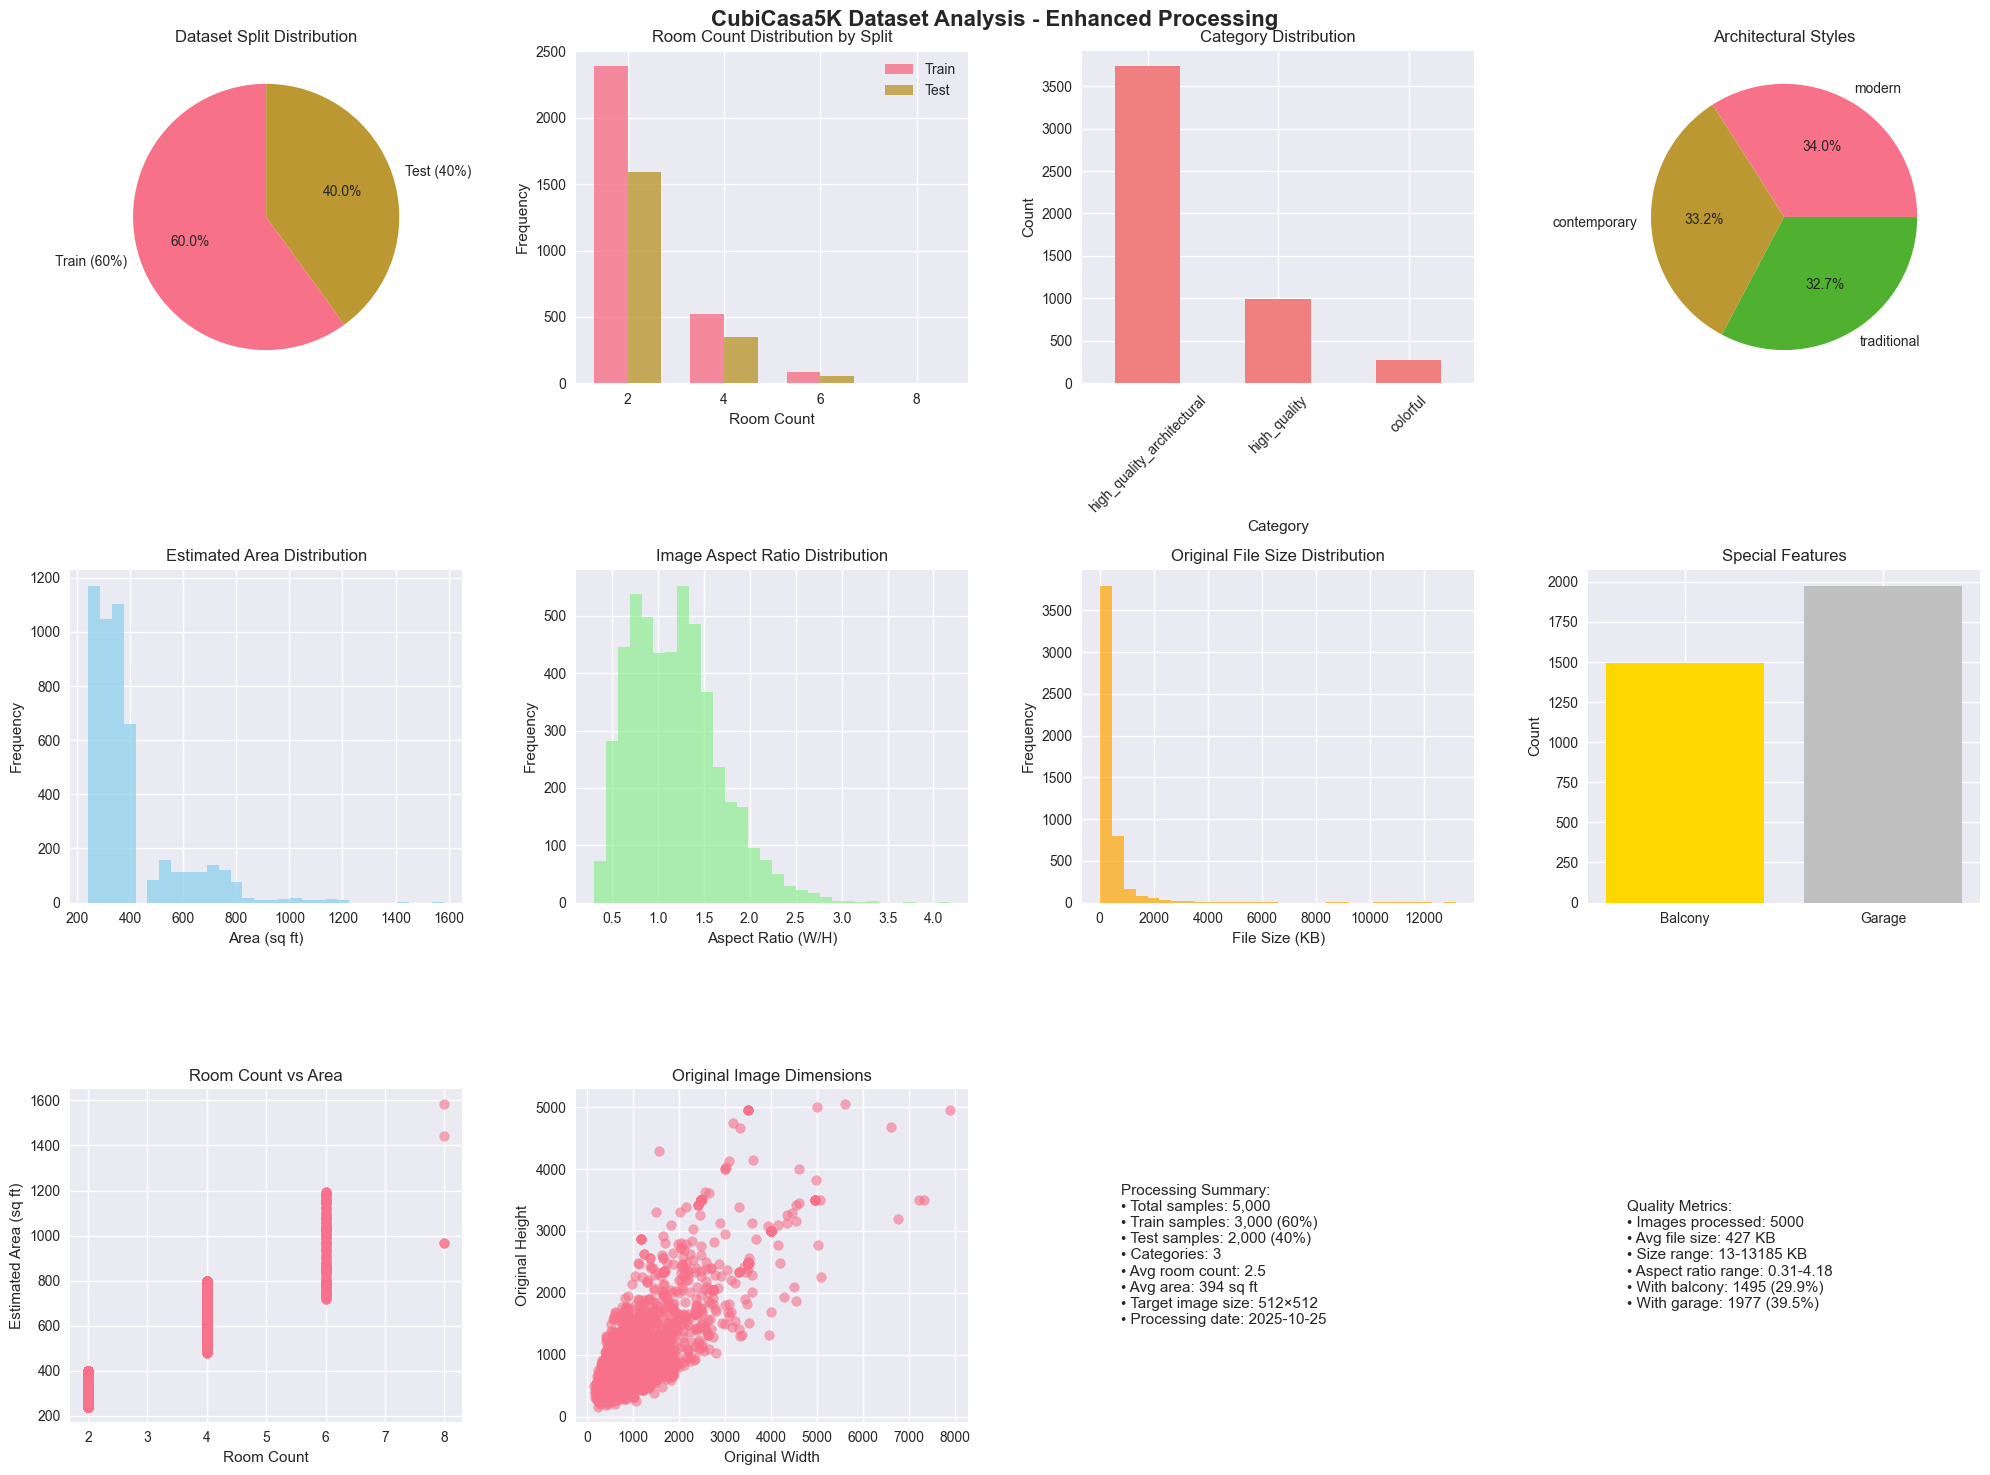

📊 Enhanced analysis saved to ../outputs/cubicasa5k_enhanced_analysis.png


In [11]:
# Create comprehensive visualization
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle('CubiCasa5K Dataset Analysis - Enhanced Processing', fontsize=16, fontweight='bold')

# 1. Dataset split distribution
split_counts = [len(train_df), len(test_df)]
split_labels = ['Train (60%)', 'Test (40%)']
axes[0,0].pie(split_counts, labels=split_labels, autopct='%1.1f%%', startangle=90)
axes[0,0].set_title('Dataset Split Distribution')

# 2. Room count distribution by split
room_count_train = train_df['room_count'].value_counts().sort_index()
room_count_test = test_df['room_count'].value_counts().sort_index()

# Align indices
all_room_counts = sorted(set(room_count_train.index) | set(room_count_test.index))
train_values = [room_count_train.get(rc, 0) for rc in all_room_counts]
test_values = [room_count_test.get(rc, 0) for rc in all_room_counts]

x_pos = np.arange(len(all_room_counts))
width = 0.35

axes[0,1].bar(x_pos - width/2, train_values, width, label='Train', alpha=0.8)
axes[0,1].bar(x_pos + width/2, test_values, width, label='Test', alpha=0.8)
axes[0,1].set_xlabel('Room Count')
axes[0,1].set_ylabel('Frequency')
axes[0,1].set_title('Room Count Distribution by Split')
axes[0,1].set_xticks(x_pos)
axes[0,1].set_xticklabels(all_room_counts)
axes[0,1].legend()

# 3. Category distribution
category_counts = df['category'].value_counts()
category_counts.plot(kind='bar', ax=axes[0,2], color='lightcoral')
axes[0,2].set_title('Category Distribution')
axes[0,2].set_xlabel('Category')
axes[0,2].set_ylabel('Count')
axes[0,2].tick_params(axis='x', rotation=45)

# 4. Architectural style distribution
style_counts = df['architectural_style'].value_counts()
style_counts.plot(kind='pie', ax=axes[0,3], autopct='%1.1f%%')
axes[0,3].set_title('Architectural Styles')
axes[0,3].set_ylabel('')

# 5. Area distribution
axes[1,0].hist(df['area_estimate'], bins=30, alpha=0.7, color='skyblue')
axes[1,0].set_title('Estimated Area Distribution')
axes[1,0].set_xlabel('Area (sq ft)')
axes[1,0].set_ylabel('Frequency')

# 6. Aspect ratio distribution
axes[1,1].hist(df['aspect_ratio'], bins=30, alpha=0.7, color='lightgreen')
axes[1,1].set_title('Image Aspect Ratio Distribution')
axes[1,1].set_xlabel('Aspect Ratio (W/H)')
axes[1,1].set_ylabel('Frequency')

# 7. File size distribution
axes[1,2].hist(df['file_size_kb'], bins=30, alpha=0.7, color='orange')
axes[1,2].set_title('Original File Size Distribution')
axes[1,2].set_xlabel('File Size (KB)')
axes[1,2].set_ylabel('Frequency')

# 8. Special features
features = ['has_balcony', 'has_garage']
feature_counts = [df[feature].sum() for feature in features]
feature_names = ['Balcony', 'Garage']

axes[1,3].bar(feature_names, feature_counts, color=['gold', 'silver'])
axes[1,3].set_title('Special Features')
axes[1,3].set_ylabel('Count')

# 9. Room count vs Area scatter
axes[2,0].scatter(df['room_count'], df['area_estimate'], alpha=0.6)
axes[2,0].set_xlabel('Room Count')
axes[2,0].set_ylabel('Estimated Area (sq ft)')
axes[2,0].set_title('Room Count vs Area')

# 10. Original image size distribution
axes[2,1].scatter(df['original_width'], df['original_height'], alpha=0.6)
axes[2,1].set_xlabel('Original Width')
axes[2,1].set_ylabel('Original Height')
axes[2,1].set_title('Original Image Dimensions')

# 11. Processing summary
axes[2,2].axis('off')
summary_text = f"""
Processing Summary:
• Total samples: {len(df):,}
• Train samples: {len(train_df):,} (60%)
• Test samples: {len(test_df):,} (40%)
• Categories: {df['category'].nunique()}
• Avg room count: {df['room_count'].mean():.1f}
• Avg area: {df['area_estimate'].mean():.0f} sq ft
• Target image size: {TARGET_SIZE[0]}×{TARGET_SIZE[1]}
• Processing date: {datetime.now().strftime('%Y-%m-%d')}
"""
axes[2,2].text(0.1, 0.5, summary_text, fontsize=11, verticalalignment='center')

# 12. Quality metrics
axes[2,3].axis('off')
quality_text = f"""
Quality Metrics:
• Images processed: {len(df)}
• Avg file size: {df['file_size_kb'].mean():.0f} KB
• Size range: {df['file_size_kb'].min()}-{df['file_size_kb'].max()} KB
• Aspect ratio range: {df['aspect_ratio'].min():.2f}-{df['aspect_ratio'].max():.2f}
• With balcony: {df['has_balcony'].sum()} ({df['has_balcony'].mean()*100:.1f}%)
• With garage: {df['has_garage'].sum()} ({df['has_garage'].mean()*100:.1f}%)
"""
axes[2,3].text(0.1, 0.5, quality_text, fontsize=11, verticalalignment='center')

plt.tight_layout()

# Save visualization
viz_file = OUTPUT_DIR / 'cubicasa5k_enhanced_analysis.png'
plt.savefig(viz_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"📊 Enhanced analysis saved to {viz_file}")

## Sample Images Visualization

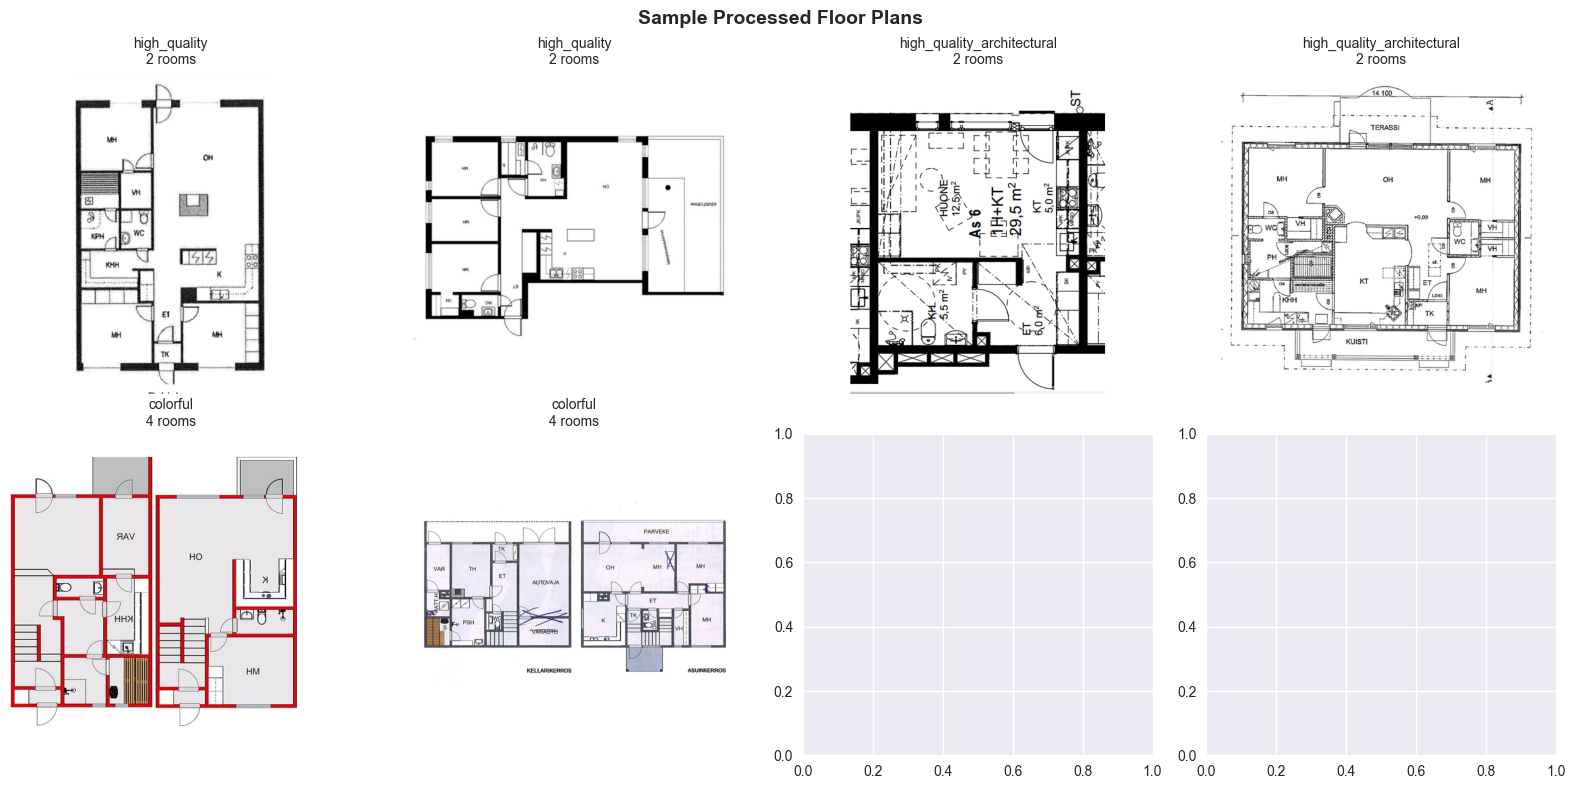

In [12]:
# Display sample processed images
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Sample Processed Floor Plans', fontsize=14, fontweight='bold')

# Get sample images from different categories
sample_indices = []
for category in df['category'].unique():
    category_samples = df[df['category'] == category].head(2)
    sample_indices.extend(category_samples.index.tolist())

sample_indices = sample_indices[:8]  # Limit to 8 samples

for i, idx in enumerate(sample_indices):
    row = df.iloc[idx]
    
    # Load processed image
    image_path = DATA_DIR.parent / row['image_path']
    
    if image_path.exists():
        image = Image.open(image_path)
        
        ax = axes[i // 4, i % 4]
        ax.imshow(image)
        ax.set_title(f"{row['category']}\n{row['room_count']} rooms", fontsize=10)
        ax.axis('off')
    else:
        ax = axes[i // 4, i % 4]
        ax.text(0.5, 0.5, 'Image not found', ha='center', va='center')
        ax.set_title(f"{row['category']}\n{row['room_count']} rooms", fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.show()

## Save Detailed Statistics

In [13]:
# Save detailed statistics
stats = {
    'dataset_info': {
        'name': 'CubiCasa5K Enhanced',
        'total_samples': len(df),
        'train_samples': len(train_df),
        'test_samples': len(test_df),
        'train_ratio': len(train_df) / len(df),
        'categories': df['category'].value_counts().to_dict(),
        'processing_date': datetime.now().isoformat()
    },
    'room_statistics': {
        'mean_room_count': float(df['room_count'].mean()),
        'std_room_count': float(df['room_count'].std()),
        'min_room_count': int(df['room_count'].min()),
        'max_room_count': int(df['room_count'].max()),
        'room_count_distribution': df['room_count'].value_counts().to_dict()
    },
    'area_statistics': {
        'mean_area': float(df['area_estimate'].mean()),
        'std_area': float(df['area_estimate'].std()),
        'min_area': float(df['area_estimate'].min()),
        'max_area': float(df['area_estimate'].max())
    },
    'image_statistics': {
        'target_size': TARGET_SIZE,
        'mean_original_width': float(df['original_width'].mean()),
        'mean_original_height': float(df['original_height'].mean()),
        'mean_aspect_ratio': float(df['aspect_ratio'].mean()),
        'mean_file_size_kb': float(df['file_size_kb'].mean())
    },
    'feature_statistics': {
        'balcony_percentage': float(df['has_balcony'].mean() * 100),
        'garage_percentage': float(df['has_garage'].mean() * 100),
        'architectural_styles': df['architectural_style'].value_counts().to_dict()
    }
}

stats_file = PROCESSED_DIR / 'cubicasa5k_enhanced_statistics.json'
with open(stats_file, 'w') as f:
    json.dump(stats, f, indent=2)

print(f"📄 Detailed statistics saved to {stats_file}")

# Display key statistics
print("\n📊 Key Statistics:")
print(f"• Total samples: {len(df):,}")
print(f"• Train/Test split: {len(train_df):,}/{len(test_df):,} ({len(train_df)/len(df):.1%}/{len(test_df)/len(df):.1%})")
print(f"• Average room count: {df['room_count'].mean():.1f} ± {df['room_count'].std():.1f}")
print(f"• Average area: {df['area_estimate'].mean():.0f} ± {df['area_estimate'].std():.0f} sq ft")
print(f"• Categories: {', '.join(df['category'].unique())}")
print(f"• Architectural styles: {', '.join(df['architectural_style'].unique())}")
print(f"• Special features: {df['has_balcony'].sum()} balconies, {df['has_garage'].sum()} garages")

📄 Detailed statistics saved to ../data/processed/cubicasa5k_enhanced_statistics.json

📊 Key Statistics:
• Total samples: 5,000
• Train/Test split: 3,000/2,000 (60.0%/40.0%)
• Average room count: 2.5 ± 1.0
• Average area: 394 ± 167 sq ft
• Categories: high_quality, high_quality_architectural, colorful
• Architectural styles: modern, traditional, contemporary
• Special features: 1495 balconies, 1977 garages


## Summary and Next Steps

In [14]:
print("🎉 Enhanced CubiCasa5K processing completed successfully!")
print(f"📊 Processed {len(df)} floor plans with {TRAIN_RATIO:.0%}/{1-TRAIN_RATIO:.0%} train/test split")
print(f"🖼️  Images resized to {TARGET_SIZE[0]}×{TARGET_SIZE[1]}")

print("\n📁 Generated Files:")
print(f"• Full dataset: {PROCESSED_DIR / 'cubicasa5k_full.csv'}")
print(f"• Train dataset: {PROCESSED_DIR / 'cubicasa5k_train.csv'}")
print(f"• Test dataset: {PROCESSED_DIR / 'cubicasa5k_test.csv'}")
print(f"• Training metadata: {DATA_DIR / 'metadata.csv'}")
print(f"• Processed images: {PROCESSED_DIR / 'images/'}")
print(f"• Statistics: {PROCESSED_DIR / 'cubicasa5k_enhanced_statistics.json'}")
print(f"• Visualization: {OUTPUT_DIR / 'cubicasa5k_enhanced_analysis.png'}")

print("\n💡 Next steps:")
print("1. Train FloorMind models:")
print("   python simple_training.py")
print("2. Or use the training pipeline:")
print("   python training/train_model.py")
print("3. Test the results:")
print("   python test_training.py")

print("\n✨ Dataset is ready for training!")

🎉 Enhanced CubiCasa5K processing completed successfully!
📊 Processed 5000 floor plans with 60%/40% train/test split
🖼️  Images resized to 512×512

📁 Generated Files:
• Full dataset: ../data/processed/cubicasa5k_full.csv
• Train dataset: ../data/processed/cubicasa5k_train.csv
• Test dataset: ../data/processed/cubicasa5k_test.csv
• Training metadata: ../data/metadata.csv
• Processed images: ../data/processed/images
• Statistics: ../data/processed/cubicasa5k_enhanced_statistics.json
• Visualization: ../outputs/cubicasa5k_enhanced_analysis.png

💡 Next steps:
1. Train FloorMind models:
   python simple_training.py
2. Or use the training pipeline:
   python training/train_model.py
3. Test the results:
   python test_training.py

✨ Dataset is ready for training!
